In [2]:
import sys
sys.path.append('/scratch/anaconda3/lib/python3.6/site-packages')



In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [4]:
directory='./.results/'
dataset='dataset_IWSLT_de-en'

file = directory + '/{}/{}_results.json'.format(dataset,dataset)
results = {}
with open(file, 'r') as f:
    results = json.load(f)

In [17]:
results.keys()
for k in results.keys():
    a = list(results[k].keys())
    break
a


['perplexities',
 'all-no_latent',
 'all',
 'source',
 'target',
 'max_len',
 'min_freq',
 'dataset',
 'opt',
 'model_pth',
 'bleu_score',
 'rng_seed',
 'combine_results',
 'use_bpe',
 'src_bpe',
 'trg_bpe',
 'model_type',
 'hidden_size',
 'num_layers',
 'dropout',
 'emb_size',
 'z_dim',
 'use_flows',
 'num_flows',
 'flow_type',
 'word_dropout',
 'kl_anneal',
 'epochs',
 'batch_size',
 'num_particles']

In [6]:
def query_results(results, keys):
    ret = {}
    for experiment in results.keys():
        info = {k: results[experiment][k] for k in keys}
        ret[experiment] = info
    return ret

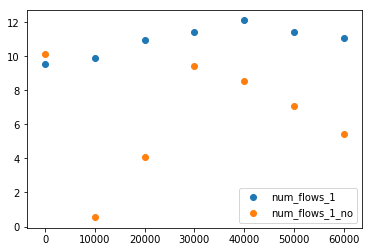

In [11]:
filtered_res = query_results(results, ['num_flows', 'kl_anneal', 'all', 'all-no_latent'])


fig, ax1 = plt.subplots()
#ax1 = fig.add_subplot(111)
for num_flows in [1]:#[0] + [2**i for i in [0, 1]]:
    items = []
    bleus_all = []
    bleus_all_no_latent = []
    kl_anneal = []
    for k, item in filtered_res.items():
        if item['num_flows'] == num_flows:
            bleus_all.append(item['all'])
            bleus_all_no_latent.append(item['all-no_latent'])
            kl_anneal.append(item['kl_anneal'])
    

    ax1.scatter(kl_anneal, bleus_all, label='num_flows_{}'.format(num_flows))
    ax1.scatter(kl_anneal, bleus_all_no_latent, label='num_flows_{}_no'.format(num_flows))
    
plt.legend();

In [83]:
options = [
 'base_kl_posterior',
 'base_kl_prior',
 'base_kl_analytic_post',
 'base_kl_analytic_prior',
 'base_kl_posterior_prior',
 'elbo',
 'nll',
 'approx_kl',
 'aux_loss',
 'perplexity']

def access_metric_by_filter(results, label, to_plot,  field, value):
    #results: dictionary where keys are experiments and assumed to have 'perplexities' as an option
    #to_plot: entry from experiments to plot
    #label: 
    entries ={}
    for exp, values in results.items():
        if values[field] == value:
            #really, perplexities should be metrics...this is a bad naming convention
            metric = [v[to_plot] for v in values['perplexities']]
            name = '{}'.format(values[label])
            entries[name] = metric 
    return entries
        
        
def perplexities_dict_plotting(results, metrics, field, value, w, h):
    #results: all the results stored in .json
    #metrics: metrics you want to create a plot of 
    #filter: single entry dict {k: v}, k = entry to filter by, v = specific value to do so by
    assert w * h == len(metrics)
    fig, axis = plt.subplots(w, h, figsize=(10,10))
    
    if not isinstance(axis, np.ndarray):
        print('hello')
        axis = np.array([axis])
    if len(axis.shape) > 1:
        axis = np.reshape(axis, (-1, ))
    
    
    for ax, metric in zip(axis, metrics):
        entries = access_metric_by_filter(results, 'num_flows', metric, field, value)
        for e in entries:
            epochs = list(range(len(entries[e])))
            ax.plot(epochs, entries[e], label=e)
        ax.set_title(metric)
        #ax.axis('off')
        ax.legend()
    
    

hello


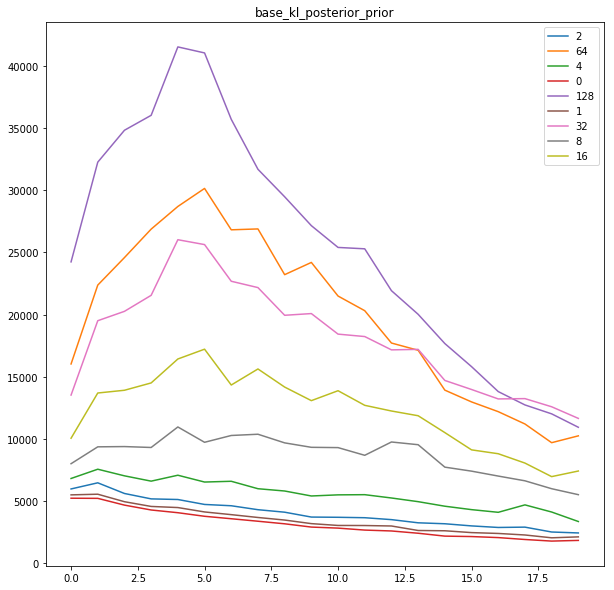

In [86]:
#to_plot = ['base_kl_posterior', 'base_kl_prior', 'nll', 'approx_kl', 'base_kl_posterior_prior', 'elbo']
to_plot = ['base_kl_posterior_prior']
perplexities_dict_plotting(results, to_plot, 'kl_anneal', 40000.0, 1, 1)

In [93]:
a = [10, 8, 1, 2]
a = sorted(a)
a


[1, 2, 8, 10]

In [140]:
def GetValuesByFlowsAsList(results, kl_anneal, value):
    values =[] 
    for exp, item in results.items():
        if item['kl_anneal'] == kl_anneal:
            values.append([item['num_flows'], item[value]])
    values = sorted(values, key=lambda x: x[0])
    #print([v[0] for v in values])
    return [v[1] for v in values]

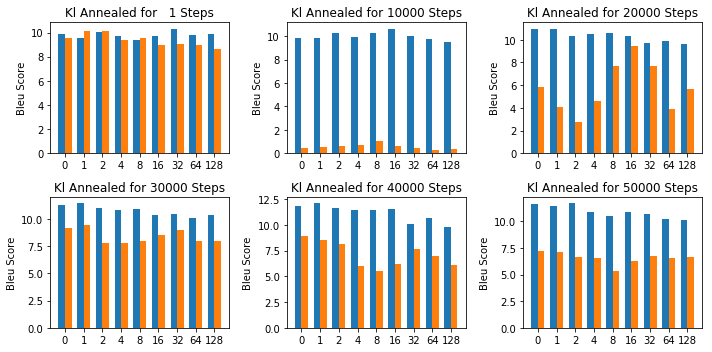

In [187]:
#For visualizing Comparison with and WITHOUT the latent variable Z for changing flows and length of KL annealing
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        """
        ax.annotate('{:6.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        """


kl_anneal=60000.0
bleus = GetValuesByFlowsAsList(results, kl_anneal, value='all')

bleus_without_z = GetValuesByFlowsAsList(results, kl_anneal, value='all-no_latent')


ind = np.arange(len(bleus))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, axis = plt.subplots(2, 3, figsize=(10,5))

kl_anneals = [1.0, 10000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0]
for i, ax in enumerate(np.reshape(axis, (-1, ))):
    kl_anneal = kl_anneals[i]
    bleus = GetValuesByFlowsAsList(results, kl_anneal, value='all')
    bleus_without_z = GetValuesByFlowsAsList(results, kl_anneal, value='all-no_latent')
    rects1 = ax.bar(ind - width/2, bleus, width, #yerr=men_std,
                label='With Z')
    rects2 = ax.bar(ind + width/2, bleus_without_z, width, #yerr=women_std,
                label='Without Z')
    autolabel(rects1, "left")
    autolabel(rects2, "right")

# Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Bleu Score')
    ax.set_title('Kl Annealed for {:3.0f} Steps'.format(kl_anneal))
    ax.set_xticks(ind)
    ax.set_xticklabels([0] + [2**i for i in range(8)])
    #ax.legend()




fig.tight_layout()

plt.show()

In [188]:
def GetValueAtEpochByFlowsAsList(results, kl_anneal, value, epoch):
    values =[] 
    for exp, item in results.items():
        if item['kl_anneal'] == kl_anneal:
            values.append([item['num_flows'], item['perplexities'][epoch][value]])
    values = sorted(values, key=lambda x: x[0])
    #print([v[0] for v in values])
    return [v[1] for v in values]

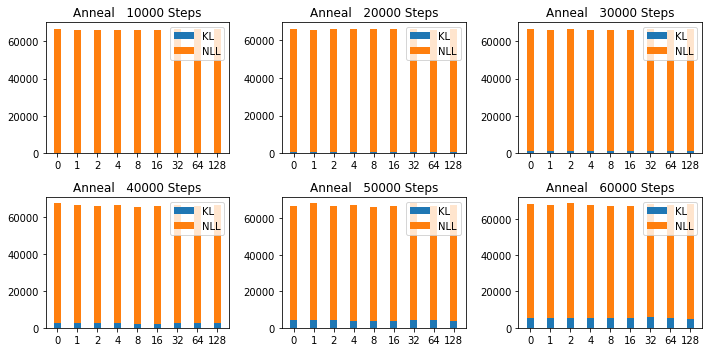

In [197]:
epoch = 19
kl_anneal = 60000.0
kl_anneals = [10000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0]
fig, axis = plt.subplots(2, 3, figsize=(10,5))

for i, ax in enumerate(np.reshape(axis, (-1, ))):
    kl_anneal = kl_anneals[i]
    nll = GetValueAtEpochByFlowsAsList(results, kl_anneal, value='nll', epoch=19)#(20, 35, 30, 35, 27)
    #approx_kl is technically the more accurate of the 2 to use...
    #^approx_kl is only thing that measure with the normalizing flows included...presumably 
    #base_kl_posterior_prior gives the actual divergence between q(z | x, y) and p(z | x)
    kl_value = 'approx_kl'
    #kl_value='base_kl_posterior_prior'
    #kl_value='base_kl_prior'
    #kl_value='base_kl_posterior'
    
    kl = GetValueAtEpochByFlowsAsList(results, kl_anneal, value=kl_value, epoch=19) #(25, 32, 34, 20, 25)
    N = len(nll)

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = ax.bar(ind, kl, width)
    p2 = ax.bar(ind, nll, width,
             bottom=kl)

    
    ax.set_xticks(ind)
    ax.set_xticklabels([0] + [2**i for i in range(8)])
    #ax.xticks(ind, [0] + [2**i for i in range(8)])
    #plt.yticks(np.arange(0, 81, 10))
    ax.legend((p1[0], p2[0]), ('KL', 'NLL'))
    ax.set_title('Anneal  {:6.0f} Steps'.format(kl_anneal))
#fig.ylabel('ELBO')
fig.tight_layout()
plt.show()

In [8]:
def BestPerformance(results, metric):
    best = 0.0
    name = "start"
    
    for exp in results.keys():
        quantity = results[exp][metric]
        if quantity > best:
            name = exp
            best = quantity
    return name, best

def WorsedPerformance(results, metric):
    worsed = 100.0
    name = "start"
    
    for exp in results.keys():
        quantity = results[exp][metric]
        if quantity < worsed:
            name = exp
            worsed = quantity
    return name, worsed

BestPerformance(results, 'all')
    

('planar_1_kl-anneal_40000.0_latents_50', 12.101130051696684)

In [9]:
WorsedPerformance(results, 'all')

('planar_8_kl-anneal_1.0_latents_50', 9.340001684348124)

In [12]:
def sortByPerformance(results, metric):
    res = []
    for exp in results.keys():
        quantity = results[exp][metric]
        res.append([exp, quantity])
    res = sorted(res, key=lambda x: x[1],reverse=True)
    return res

sortByPerformance(results, 'all')

[['planar_1_kl-anneal_40000.0_latents_50', 12.101130051696684],
 ['planar_0_kl-anneal_40000.0_latents_50', 11.871871200738978],
 ['planar_2_kl-anneal_50000.0_latents_50', 11.689584312667634],
 ['planar_0_kl-anneal_50000.0_latents_50', 11.653722362584201],
 ['planar_2_kl-anneal_40000.0_latents_50', 11.607455999015954],
 ['planar_16_kl-anneal_40000.0_latents_50', 11.541394028896091],
 ['planar_4_kl-anneal_40000.0_latents_50', 11.475204731342922],
 ['planar_8_kl-anneal_40000.0_latents_50', 11.448561499770612],
 ['planar_1_kl-anneal_30000.0_latents_50', 11.446612952550149],
 ['planar_1_kl-anneal_50000.0_latents_50', 11.423548279883628],
 ['planar_2_kl-anneal_60000.0_latents_50', 11.307235612282083],
 ['planar_0_kl-anneal_30000.0_latents_50', 11.269161515655128],
 ['planar_8_kl-anneal_60000.0_latents_50', 11.137031282231044],
 ['planar_0_kl-anneal_60000.0_latents_50', 11.100108947860218],
 ['planar_1_kl-anneal_60000.0_latents_50', 11.09965428356581],
 ['planar_2_kl-anneal_30000.0_latents_50